My notes from working through [Practical statistics for data science](https://learning.oreilly.com/library/view/practical-statistics-for/9781492072935/), to revise consepts and get comfortable implementing them in Python.

Terminology:
- Stochastic is a synonym for random. A stochastic process is a random process. The distinction between *stochastics* and *statistics* is that a stochastic processes generate the data we analyse in statistics.

Sampling:

- We rely on a sample to learn about a larger population.
- We thus need to make sure that the sampling procedure is free of bias, so that units in the sample are representative of those in the population.
- While representativeness cannot be achieved perfectly, it's important to ensure that non-representativeness is due to random error and not due to systematic bias.
- Random errors produces deviations that vary over repeated samples, while systematic bias persists. Such selection bias can lead to misleading and ephemeral conclusions.
- Two basic sampling procedures are simple random sampling (randomly select $n$ units from a population of $N$) and stratified random sampling (randomly select $n_s$ from each stratum $S$ of a population of $N$).
- The mean outcome of the population is denoted $\bar{x}$, that of the population $\mu$.
- Using the data to answer many questions will eventually reveal something interesting by mere chance (if 20,000 people flip a coin 10 times, some will have 10 straight heads). This is sometimes called the Vast Search Effect.
- Common types of selection bias in data science:
    - The vast search effect
    - Nonrandom sampling
    - Cherry-picking data
    - Selecting specific time-intervals
    - Stopping experiments prematurely
- Ways to guard against selection bias: have one or many holdout datasets to confirm your results.
- Regression to the mean results form a particular kind of selection bias in a setting we measure outcomes repeatedly over time: when luck and skill combine to determine outcomes, winners of one period will be less lucky next period and perform closer to the mean performer.

Sampling distributions

- A sampling distribution is the distribution of a statistic (e.g. the mean) over many repeated samples. Classical statistics is much concerned with making inferences from samples about the population based on such statistics.
- When we measure an attribute of the population based on a sample using a statistic, the result will vary over repeated samples. To capture by how much it varies, we are concerned with the sampling variability.

- Key distinctions:
    - The data distribution is the distribution of the data in the sample, the sampling distribution is the distribution of the sample statistic.
    - The standard deviation is a measure of spread of the data distribution, the standard error a measure of spread of the sampling distribution.

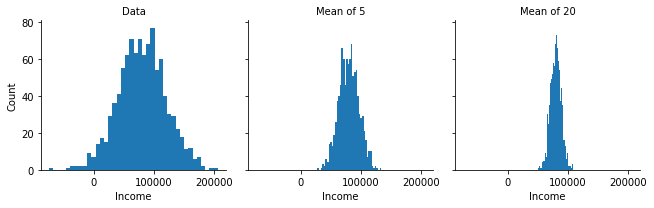

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt

full_data = norm.rvs(80000, 40000, 1000000)

sample_data = pd.DataFrame({
    'income': np.random.choice(full_data, 1000),
    'type': 'Data'
})
mof5 = pd.DataFrame({
    'income': [np.random.choice(full_data, 5).mean() for _ in range(1000)],
    'type':'Mean of 5'
})
mof20 = pd.DataFrame({
    'income': [np.random.choice(full_data, 20).mean() for _ in range(1000)],
    'type':'Mean of 20'
})
results = pd.concat([sample_data, mof5, mof20])

g = sns.FacetGrid(results, col='type')
g.map(plt.hist, 'income', bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}');

Plots show that:
- Data distribution has larger spread than sampling distributions
- The spread of sampling distributions decreases with increasing sample size

Central limit theorem

- The second point above is an instance of the central limit theorem, which states that means from multiple samples are normally distributed even if the underlying distribution is not normal, provied that the sample size is large enough.

- More precisely: Suppose that we have a sequence of independent and identically distributed (iid) random variables $\{x_1, ..., x_n\}$ drawn from a distribution with expected value $\mu$ and finite variance given by $\sigma^2$, and we are interested in the mean value $\bar{x} = \frac{x_1 + ... + x_n}{n}$. By the law of large numbers, $\bar{x}$ converges to $\mu$. The central limite theorem describes the shape of the random variation of $\bar{x}$ around $\mu$ during this convergence. In particular, for large enough $n$, the distribution of $\bar{x}$ will be close to a normal distribution with mean $\mu$ and standard deviation $\sigma/n$.

- This is useful because it means that irrespective of the underlying distribution (i.e. the distribution of the values in our sequence above), we can use the normal distribution and approximations to it (such as the t-distribution) to calculate sample distributions when we do inference. Because of this, the CLT is at the heart of the theory of hypothesis testing and confidence intervals, and thus of much of classical statistics.

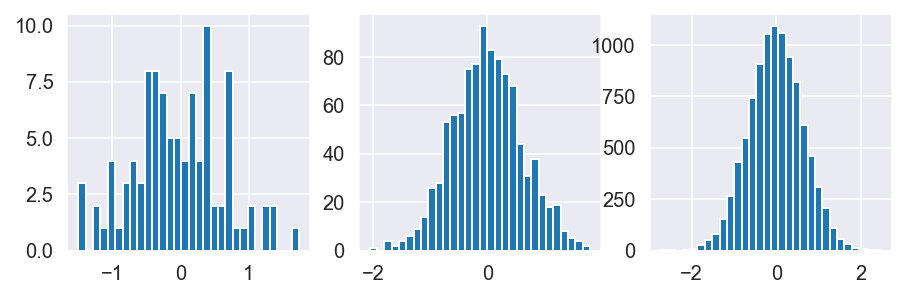

In [14]:
# CLT demo

from scipy.stats import norm, gamma
import matplotlib.pyplot as plt

def means(n):
    return [np.mean(norm.rvs(0, 2, 10)) for _ in range(n)]

plt.subplots(figsize=(10,10))

plt.subplot(441)
plt.hist(means(100), bins=30)
plt.subplot(442)
plt.hist(means(1000), bins=30)
plt.subplot(443)
plt.hist(means(10000), bins=30);

Standard error

- The standard error is a measure for the variability of the sampling distribution. 
- It is related to the standard deviation of the observations, $\sigma$ and the sample size $n$ in the following way:

$$
se = \frac{\sigma}{\sqrt{n}}
$$

- The relationship between sample size and se is sometimes called the "Square-root of n rule", since reducing the $se$ by a factor of 2 requires an increase in the sample size by a factor of 4.

Bootstrap

- In practice, we often use the bootstrap to calculate standard errors of model parameters or statistics.
- Conceptually, the bootstrap works as follows: 1) we draw an original sample and calculate our statistic, 2) we then create a blown-up version of that sample by duplicating it many times, 3) we then draw repeated samples from the large sample, recalculate our statistic, and calculate the standard deviation of these statistics to get the standard error.
- To achieve this easily, we can skip step 2) by simply sampling with replacement from the original distribution in step 3).
- The full procedure makes clear what the bootstrap results tell us, however: they tell us how lots of additional samples would behave if they were drawn from a population like our original sample.
- Hence, if the original sample is not representative of the population of interest, then bootstrap results are not informative about that population either.
- The bootstrap can also be used to improve the performance of classification or regression trees by fitting multiple trees on bootstrapped sample and then averaging their predictions. This is called "bagging", short for "bootstrap aggregating".


In [134]:
# A simple bootstrap implementation

from sklearn.utils import resample

original_sample = norm.rvs(50000, 30000, 1000)

results = []
for nrepeat in range(1000):
    sample = resample(original_sample)
    results.append(np.median(sample))
print('Bootstrap Statistics:')
print(f'Original: {np.median(original_sample)}')
print(f'Bias: {np.median(results) - np.median(original_sample)}')
print(f'Std. error: {np.std(results)}')

Bootstrap Statistics:
Original: 48463.72860114132
Bias: -1.9266121069231303
Std. error: 1107.4684180412535


Confidence intervals

- A CI is another way to learn about the variability of a test statistic. 
- It can be calculated using the (standard) normal distribution or the t-distribution (if sample sizes are small).
- But for data science purposes we can compute a x percent CI from the bootstrap, following this algorithm: 1) Draw a large number of bootstrap samples and calculate the statistic of interest, 2) Trim [(100-x)/2] percent of the bootstrap results on either end of the distribution, 3) the trim points are the end point of the CI.

The normal distribution

- Useful not mainly because data is generally normally distributed, but because sample distributions of statistics (as well as errors) often are.
- But rely on normality assumption only as a last resort if using empirical distributions or bootstrap is not available. 
- A QQ-plot is a useful way to check whehter data is roughly normal, in which case points are on the line and clustered towarrds the centre of the plot.

Probability plots

(For this, I'm heavily drawing on [this](https://towardsdatascience.com/explaining-probability-plots-9e5c5d304703) article great article and the companion [Jupyter](https://github.com/erykml/medium_articles/blob/master/Statistics/probability_plots.ipynb) notebook.)

- Probability plots help us visually compare two sets of data and to check whether they come from different or similar distributions.
- Probability plots vary along two axis: what they compare and how they compare it. They can compare either two empirical sets of data, two theoretical sets of data, or -- most commonly -- an empirical and a theoretical set of data (as in when we check whether OLS residuals are normally distributed). And we can compare distributions in two different ways: by looking at their CDFs (P-P plots), or by looking at quantiles (Q-Q plots).

In [1]:
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
# import probscale

%config InlineBackend.figure_format ='retina'
sns.set_style('darkgrid')
sns.mpl.rcParams['figure.figsize'] = (10.0, 6.0)

In [4]:
# Generating random samples

n = 10000
rv_std_normal = np.random.normal(size=n)
rv_normal = np.random.normal(1, 2.5, n)
rv_skew_normal = stats.skewnorm.rvs(a=5, size=n)

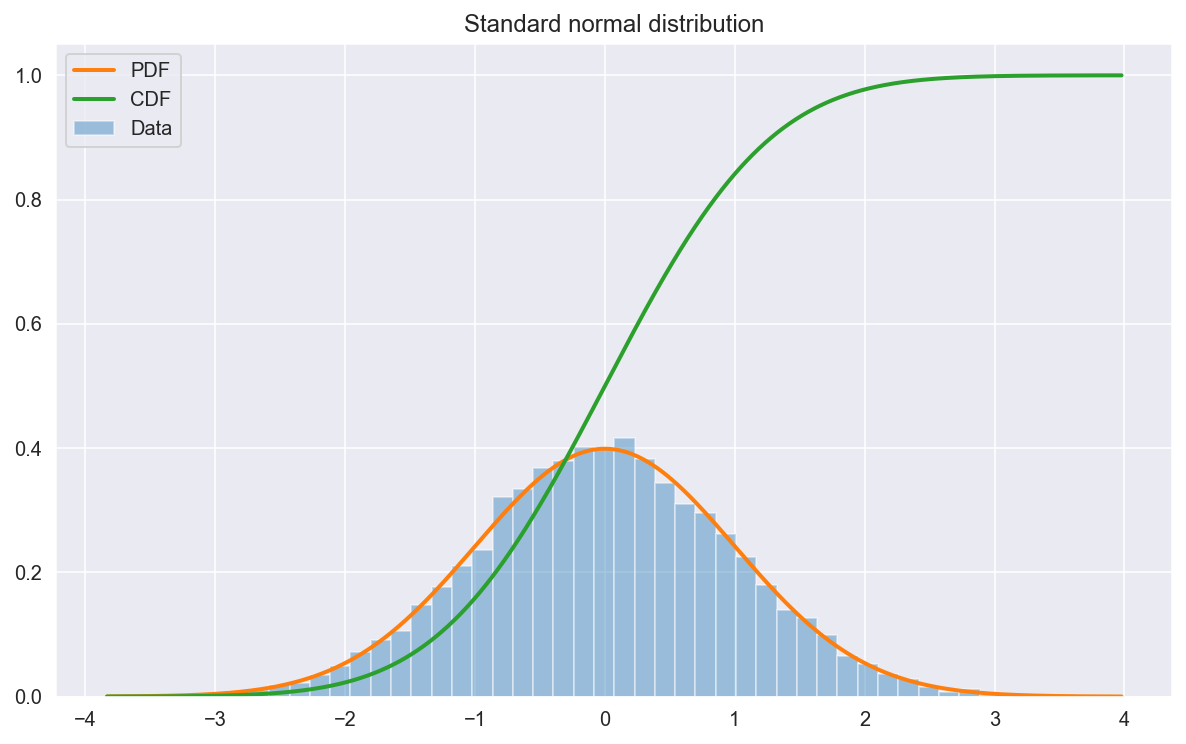

In [6]:
# Drawing histogram, pdf, and cdf of std normal sample

x = np.linspace(min(rv_std_normal), max(rv_std_normal), 1000);

pdf = stats.norm.pdf(x)
cdf = stats.norm.cdf(x)

ax = sns.distplot(rv_std_normal, kde=False, norm_hist=True, label='Data')
ax.plot(x, pdf, lw=2, label='PDF')
ax.plot(x, cdf, lw=2, label='CDF')

ax.set_title('Standard normal distribution')
ax.legend();

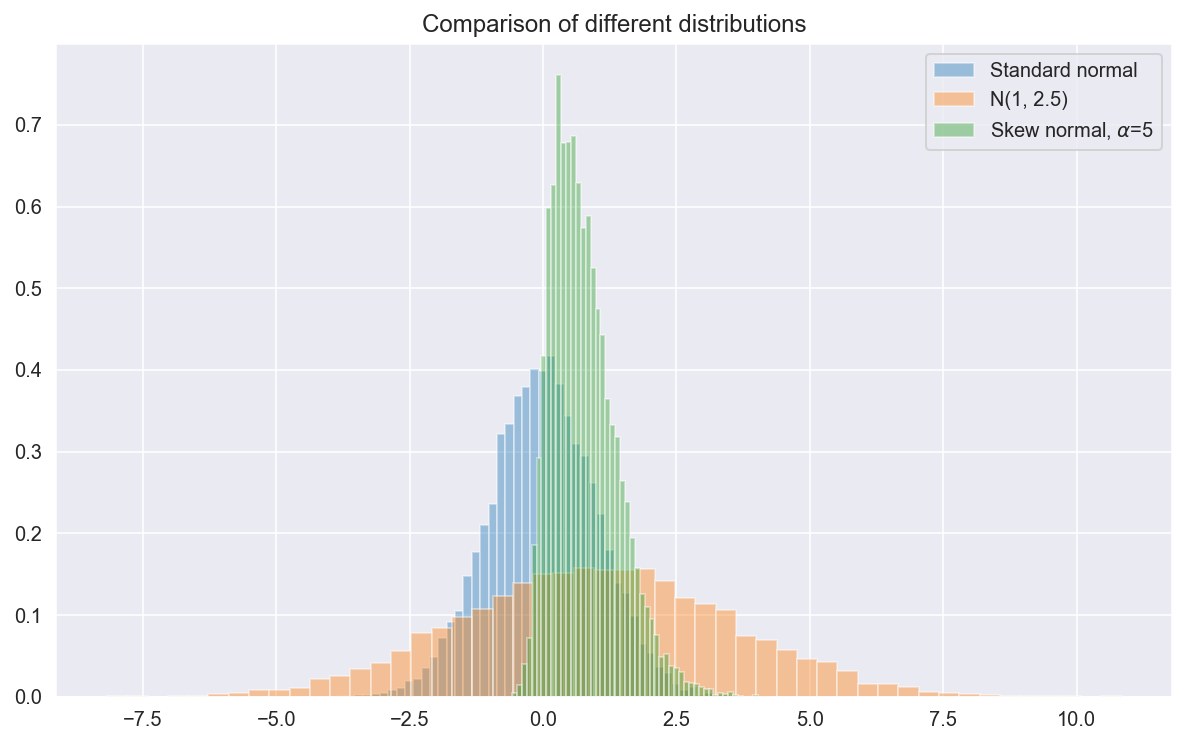

In [7]:
# Compare three distributions

ax = sns.distplot(rv_std_normal, kde=False, norm_hist=True, label='Standard normal')
ax = sns.distplot(rv_normal, kde=False, norm_hist=True, label='N(1, 2.5)')
ax = sns.distplot(rv_skew_normal, kde=False, norm_hist=True, label='Skew normal, $\\alpha$=5')
ax.set_title('Comparison of different distributions')
ax.legend();

PP-plots

- As the original [post](https://towardsdatascience.com/explaining-probability-plots-9e5c5d304703) explains, Probability-Probability-plots compare the CDFs of two distributions.

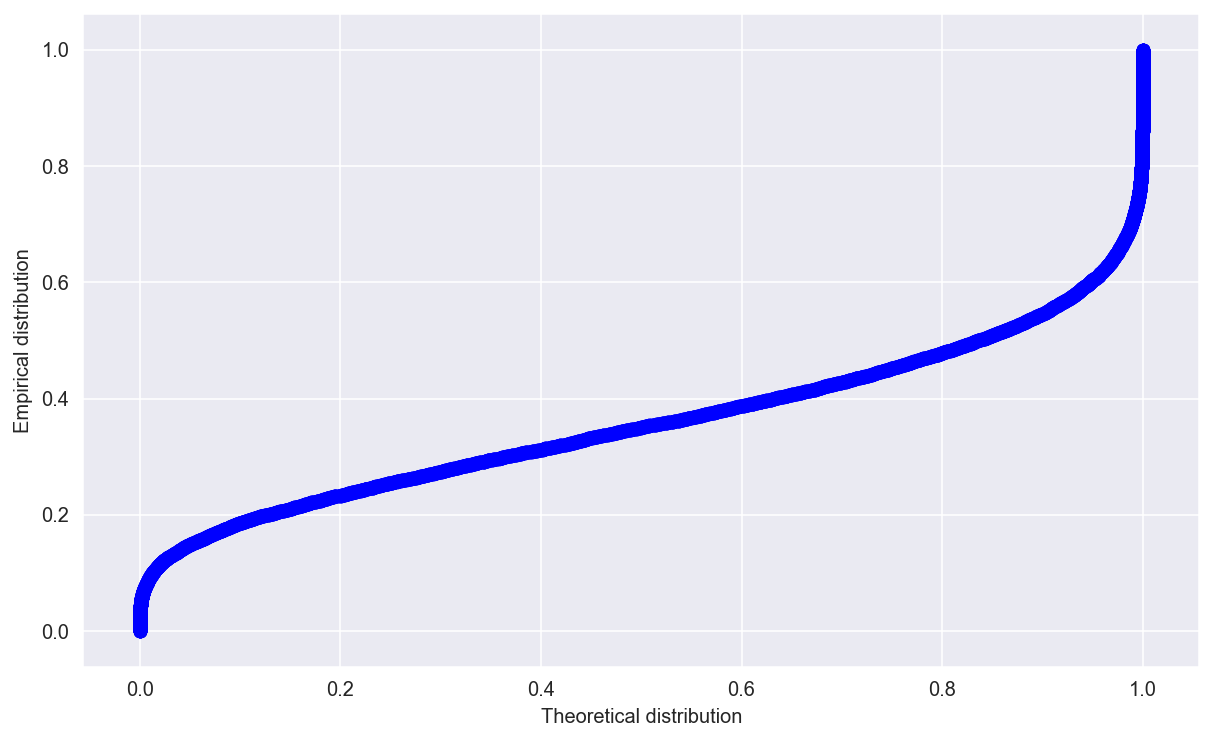

In [90]:
data = rv_normal
n = len(data)

p_data = np.arange(1, n + 1) / (n - 0.5 / n)
p_theoretical = np.sort(norm.cdf(data))

ax = sns.scatterplot(p_theoretical, p_data, color='blue', edgecolor='blue')
ax.set_xlabel('Theoretical distribution')
ax.set_ylabel('Empirical distribution');

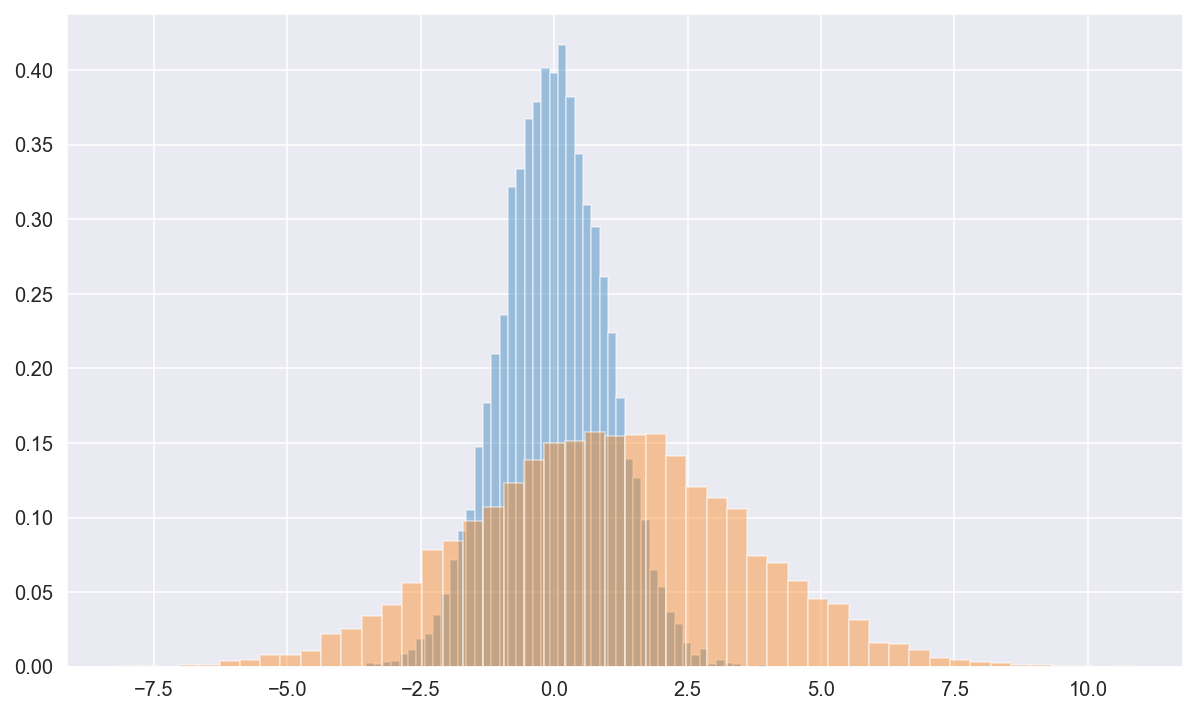

In [84]:
ax = sns.distplot(rv_std_normal, kde=False, norm_hist=True)
ax = sns.distplot(rv_normal, kde=False, norm_hist=True)


In [ ]:
def pp_plot(x, dist, line=True, ax=None):
    '''
    Function for comparing empirical data to a theoretical distribution by using a P-P plot.
    
    Params:
    x - empirical data
    dist - distribution object from scipy.stats; for example scipy.stats.norm(0, 1)
    line - boolean; specify if the reference line (y=x) should be drawn on the plot
    ax - specified ax for subplots, None is standalone
    '''
    if ax is None:
        ax = plt.figure().add_subplot(1, 1, 1)
        
    n = len(x)
    p = np.arange(1, n + 1) / n - 0.5 / n
    pp = np.sort(dist.cdf(x))
    sns.scatterplot(x=p, y=pp, color='blue', edgecolor='blue', ax=ax)
    ax.set_title('PP-plot')
    ax.set_xlabel('Theoretical Probabilities')
    ax.set_ylabel('Sample Probabilities')
    ax.margins(x=0, y=0)
    
    if line: ax.plot(np.linspace(0, 1), np.linspace(0, 1), 'r', lw=2)
    
    return ax

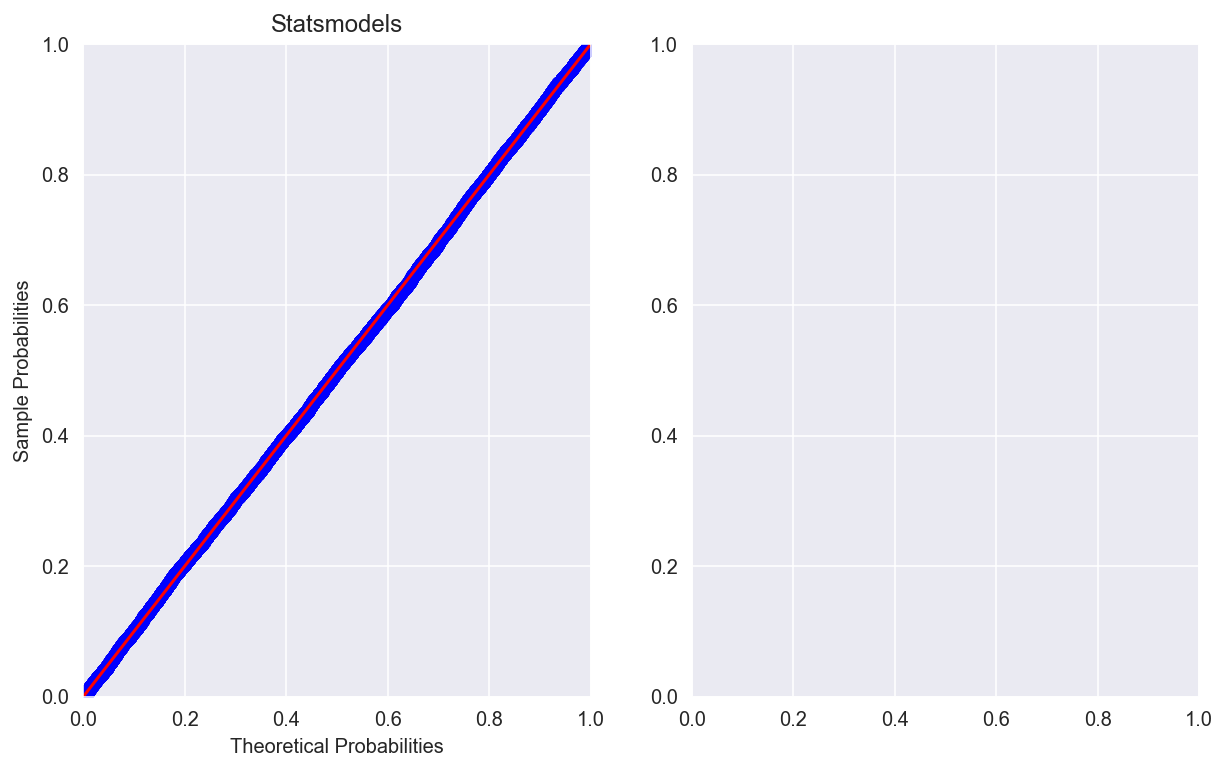

In [11]:
fig, ax = plt.subplots(1, 2)

sm.ProbPlot(rv_std_normal, stats.norm).ppplot(line='45', ax=ax[0])
ax[0].set_title('Statsmodels');



In [ ]:
# compare statsmodels and my implementation of PP plots for Standard Normal distr

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

fig.suptitle('PP-plots', fontsize=22)

sm.ProbPlot(rv_std_norm, scs.norm, loc=0, scale=1).ppplot(line='45', ax=ax[0])
ax[0].set_title('Statsmodels', fontsize=16)

pp_plot(rv_std_norm, scs.norm(loc=0, scale=1), ax=ax[1])
ax[1].set_title('pp_plot', fontsize=16)

plt.show()

Q-Q plots

- A the x percent quantile is a line in the data such that x percent of the data are below and 100 - x percent of the data are above the line (it's also equal to the xth percentile).



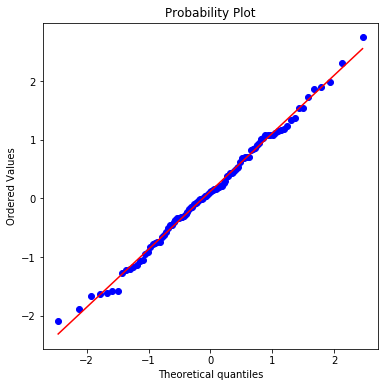

In [142]:
# A QQ-plot of normal data

from scipy.stats import norm, probplot

fig, ax = plt.subplots(figsize=(6, 6))
norm_sample = norm.rvs(size=100)
probplot(norm_sample, plot=ax);

Long-tailed distributions

- As noted above, while errors and statistics are often normally distributed, data is usually not.
- The probability plot below plots Netflix stock returns against a normal distribution, and shows that the distribution has heavier tails than a normal distribution (i.e. extreme events are more likely).


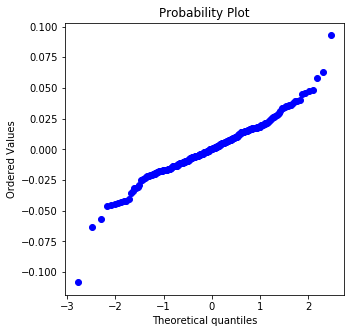

In [187]:
import os
import pandas_datareader as pdr
from dotenv import load_dotenv
from datetime import datetime
load_dotenv()

nflx = np.log(pdr.get_data_tiingo('NFLX', start, end, api_key=os.getenv('tiingo_api_key'))['close']).diff()

start = datetime(2019, 1, 1)
end = datetime(2019, 12, 31)

fix, ax = plt.subplots(figsize=(5,5))
probplot(nflx, plot=ax);

Binomial distribution

In [203]:
from scipy.stats import binom

binom.pmf(2, n=5, p=0.5)
binom.cdf(3, n=5, p=0.5)

0.8125

Linear regression and regression diagnostic

Follow [this](https://github.com/erykml/medium_articles/blob/master/Statistics/linear_regression_assumptions.ipynb) notebook.

# Misc

In [25]:
# Comparing speed of generating random samples with numpy and scipy

%%timeit
np.random.normal(size=10)

3.34 µs ± 38 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [24]:
%%timeit
norm.rvs(size=10)

33.9 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Turns out numpy is about ten times faster –- 3.3 microseconds (10e^-6s) compared to 33 microseconds.